In [10]:
import numpy as np
from numpy import sqrt
from numpy.linalg import inv
from numpy import log
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
import os
os.chdir('/Users/sifanliu/Dropbox/Dual Sketch/RidgeRegression')

In [2]:
# generate a uniformly distributed orthogonal matrix
def generate_haar_matrix(n, p):
    if n <= p:
        return np.linalg.qr(np.random.randn(p, n))[0].T
    else:
        return np.linalg.qr(np.random.randn(n, p))[0]


def theta_1(lbd, gamma):
    z_2 = -0.5 * (sqrt(gamma) + (1 + lbd) / sqrt(gamma) + sqrt((sqrt(gamma) + (1 + lbd) / sqrt(gamma)) ** 2 - 4))
    return -(1 + lbd) / (gamma * lbd) - z_2 / (sqrt(gamma) * lbd)


def theta_2(lbd, gamma):
    delta = (sqrt(gamma) + (1 + lbd) / sqrt(gamma)) ** 2 - 4
    return -1 / (gamma * lbd ** 2) + (gamma + 1) / (2 * gamma * lbd ** 2) - 1 / (2 * sqrt(gamma)) * (
            (lbd + 1) / gamma + 1) / (lbd * sqrt(delta)) + 1 / (2 * sqrt(gamma)) * sqrt(delta) / (lbd ** 2)


# MSE of ridge regression, no sketching
def MSE_original(lbd, gamma, alpha=1, sigma=1, verbose=0):
    the_1 = theta_1(lbd, gamma)
    the_2 = theta_2(lbd, gamma)
    bias = alpha ** 2 * lbd ** 2 * the_2
    variance = gamma * sigma ** 2 * (the_1 - lbd * the_2)
    if verbose == 0:
        return bias + variance
    else:
        return bias + variance, bias, variance
    

# MSE of orthogonal dual sketch
def MSE_dual(lbd, gamma, zeta, alpha=1.0, sigma=1.0, verbose=0):
    the_1 = theta_1(lbd, zeta) * zeta + (1 - zeta) / lbd
    the_2 = theta_2(lbd, zeta) * zeta + (1 - zeta) / lbd ** 2
    bias_1 = alpha ** 2 / gamma * (
            1 + (lbd + zeta - gamma) ** 2 * the_2 + 2 * (gamma - zeta - lbd) * the_1 + (
            gamma - zeta) * the_1 ** 2)
    bias_2 = -2 * alpha ** 2 / gamma * (1 - (lbd + zeta - gamma) * the_1)
    bias = bias_1 + bias_2 + alpha ** 2
    variance = sigma ** 2 * (the_1 - (lbd + zeta - gamma) * the_2)
    if verbose == 0:
        return bias + variance
    else:
        return bias + variance, bias, variance


# compute the Stieltjes transform of MP
def MP_Stieltjes(z, gamma):
    return (1 - gamma - z - sqrt((1 + gamma - z) ** 2 - 4 * gamma)) / (2 * gamma * z)


# compute the Stieltjes transform of inv-MP
def inv_MP_Stieltjes(z, gamma):
    return -1 / z - 1 / z ** 2 * MP_Stieltjes(1 / z, gamma)


# compute the R-transform of MP
def MP_R(z, gamma):
    return 1 / (1 - gamma * z)


# compute the R-transform of inv-MP
def inv_MP_R(z, gamma):
    a = (z + 1) * gamma
    b = -z * gamma * (1 + gamma)
    c = (z * gamma) ** 2
    w = (-b + sqrt(b ** 2 - 4 * a * c)) / (2 * a)
    w2 = (-b - sqrt(b ** 2 - 4 * a * c)) / (2 * a)
    # print(w2)
    # w2 = (z * (gamma + 1) - sqrt(z ** 2 * (gamma + 1) ** 2 - 4 * gamma * (z + 1) * z ** 2)) / (2 * (z + 1) * gamma)
    num = 8 * (z + 1) ** 2 * gamma ** 2
    den = z * (gamma + 1 + sqrt((gamma + 1) ** 2 - 4 * gamma * (z + 1)))
    # return num / den - 1 / z
    return 1 / w2 - 1 / z


# compute the inverse of the Stieltjes transform of inv-MP
def inv_MP_Stieltjes_inv(z, gamma, xi, lbd):
    return 1 / (1 + z / xi) - (gamma - 1 - sqrt((gamma - 1) ** 2 + 4 * lbd * z)) / (2 * z) - 1 / z


# compute the Stieltjes transform of inv-MP evaluated at zero
def inv_MP_Stieltjes_0(gamma, xi, lbd):
    maxiter = 100
    tol = 1e-8
    low = 0.01
    high = 2
    if inv_MP_Stieltjes_inv(low, gamma, xi, lbd) * inv_MP_Stieltjes_inv(high, gamma, xi, lbd) > 0:
        print("no root")
        return
    err = 1
    old = 0
    for i in range(maxiter):
        mid = (low + high) / 2
        if inv_MP_Stieltjes_inv(low, gamma, xi, lbd) * inv_MP_Stieltjes_inv(mid, gamma, xi, lbd) < 0:
            high = mid
        else:
            low = mid
        if abs(old - inv_MP_Stieltjes_inv(mid, gamma, xi, lbd)) < tol:
            print("converged")
            break
        old = inv_MP_Stieltjes_inv(mid, gamma, xi, lbd)
    return mid


# compute the first order derivative of the inverse function of the Stieltjes transform of inv-MP
def diff_MP(z, gamma, xi, lbd):
    epsilon = 1e-5
    tol = 1e-8
    maxiter = 100
    ans = (inv_MP_Stieltjes_inv(z + epsilon, gamma, xi, lbd) - inv_MP_Stieltjes_inv(z - epsilon, gamma, xi, lbd)) / (2 * epsilon)
    old = ans
    for i in range(maxiter):
        ans = (inv_MP_Stieltjes_inv(z + epsilon, gamma, xi, lbd) 
               - inv_MP_Stieltjes_inv(z - epsilon, gamma, xi, lbd)) / (2 * epsilon) 
        if abs(old - ans) < tol:
            print('converged')
            return ans
        old = ans
        epsilon = epsilon / 2
    return ans
        

# compute the first order derivative evaluated at 0 of the Stieltjes transform of inv-MP
def inv_MP_Stieltjes_derivative_0(gamma, xi, lbd):
    m_0 = inv_MP_Stieltjes_0(gamma, xi, lbd)
    print(m_0)
    return 1 / diff_MP(m_0, gamma, xi, lbd)
 

In [3]:
n = 500
gamma = 0.9
p = int(n * gamma)
alpha = 1
sigma = 1e-7
num_steps = 20
zeta_seq = np.linspace(1, 2, num_steps)
dual_simu = np.zeros((num_steps, 3))
dual_theo = np.zeros((100, 3))
rep = 10
lbd_seq = [0.1, 0.3, 0.5]

In [10]:
# orthogonal dual projection
for j in range(1):
    lbd = gamma * sigma ** 2 / alpha ** 2
    for i in range(num_steps):
        zeta = zeta_seq[i]
        d = int(n * zeta)
        for k in range(rep):
            X = np.random.randn(n, p)
            beta = np.random.randn(p, 1) * alpha / sqrt(p)
            epsilon = np.random.randn(n, 1) * sigma
            Y = X @ beta + epsilon
            R = generate_haar_matrix(p, d)
            beta_dual = X.T / n @ inv(X @ R @ R.T @ X.T / n + lbd * np.identity(n)) @ Y
            dual_simu[i, j] = dual_simu[i, j] + np.linalg.norm(beta_dual - beta) ** 2 / rep

In [297]:
zeta_seq_2 = np.linspace(0.1, 0.5, 100) 
for j in range(1):
    lbd = gamma * sigma ** 2 / alpha ** 2
    for i in range(100):
        zeta = zeta_seq_2[i]
        dual_theo[i, j] = MSE_dual(lbd, gamma, zeta, alpha, sigma, verbose=1)[0]

In [4]:
n = 500
p = 700
d = 600
gamma = p / n
xi = d / n
alpha = 1
sigma = 1e-8
num_steps = 10
zeta_seq = np.linspace(0.1, 2, num_steps)
rep = 50
dual_simu_gaus = np.zeros((rep, num_steps))
lbd = 1

In [5]:
# Gaussian dual projection
for i in range(num_steps):
    zeta = zeta_seq[i]
    d = int(n * zeta)
    for k in range(rep):
        X = np.random.randn(n, p)
        beta = np.random.randn(p, 1) * alpha / sqrt(p)
        epsilon = np.random.randn(n, 1) * sigma
        Y = X @ beta 
        R = np.random.randn(p, d) / sqrt(d)
        # R = generate_haar_matrix(p, d)
        beta_dual = X.T / n @ inv(X @ R @ R.T @ X.T / n + lbd * np.identity(n)) @ Y
        dual_simu_gaus[k, i] = norm(beta_dual - beta) ** 2


In [6]:
# theoretical part
zeta_seq_2 = np.linspace(0.1, 2, 100)
theo_gaus = np.zeros(100)
for j in range(1):
    lbd = gamma * sigma ** 2 / alpha ** 2
    lbd = 1
    for i in range(100):
        zeta = zeta_seq_2[i]
        bias_1 = alpha ** 2
        bias_2 = 2 * alpha ** 2 / gamma * inv_MP_Stieltjes_0(gamma, zeta, lbd)
        bias_3 = alpha ** 2 / gamma * inv_MP_Stieltjes_derivative_0(gamma, zeta, lbd)
        theo_gaus[i] = bias_1 - bias_2 + bias_3

converged
converged
1.1871523558348418
converged
converged
converged
1.152420945242047
converged
converged
converged
1.1195826909691098
converged
converged
converged
1.0885865003615618
converged
converged
converged
1.0593732743710285
converged
converged
converged
1.0318772419542075
converged
converged
converged
1.0060270275920624
converged
converged
converged
0.9817471339553592
converged
converged
converged
0.9589591873437164
converged
converged
converged
0.9375833610445257
converged
converged
converged
0.9175394428521395
converged
converged
converged
0.8987479322403668
converged
converged
converged
0.8811308335885404
converged
converged
converged
0.864612575434148
converged
converged
converged
0.8491203514859078
converged
converged
converged
0.8345846988633274
converged
converged
converged
0.8209396686032413
converged
converged
converged
0.8081230480596424
converged
converged
converged
0.7960763757303355
converged
converged
converged
0.7847450153902171
converged
converged
converged
0.

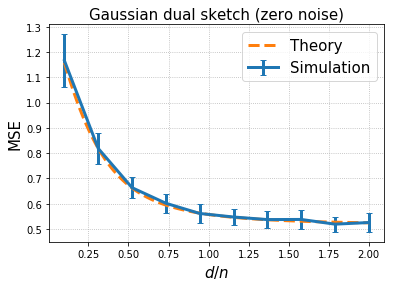

In [11]:
# plt.figure(1, figsize=(12, 8))
xx = np.mean(dual_simu_gaus, axis=0)
yerr = np.std(dual_simu_gaus, axis=0)
plt.errorbar(zeta_seq, xx, yerr, capsize=3, lw=3, label='Simulation')
plt.plot(zeta_seq_2, theo_gaus, lw=3, ls='--', label='Theory')
# plt.plot(zeta_seq_2, np.ones(100) * MSE_original(lbd, gamma, alpha, sigma), lw=3, ls='-.', label='No sketching')
plt.grid(linestyle='dotted')
plt.legend(fontsize=15)
plt.xlabel(r'$d/n$', fontsize=15)
plt.ylabel(r'MSE', fontsize=15)
plt.title('Gaussian dual sketch (zero noise)', fontsize=15)
plt.savefig('./Plots/dual_gaus_gamma_{}_alpha_{}_lbd_{}.png'.format(gamma, alpha, lbd))

In [5]:
zeta_seq_2 = np.linspace(0.1, 10, 100)
theo_gaus = np.zeros(100)
for j in range(1):
    lbd = gamma * sigma ** 2 / alpha ** 2
    lbd = 1
    for i in range(100):
        zeta = zeta_seq_2[i]
        bias_1 = alpha ** 2
        bias_2 = 2 * alpha ** 2 / gamma * inv_MP_Stieltjes_0(gamma, zeta, lbd)
        bias_3 = alpha ** 2 / gamma * inv_MP_Stieltjes_derivative_0(gamma, zeta, lbd)
        theo_gaus[i] = bias_1 - bias_2 + bias_3


converged
converged
0.7403707632794974
converged
converged
converged
0.6342223634943365
converged
converged
converged
0.5659191832132635
converged
converged
converged
0.5212173954583703
converged
converged
converged
0.49076707040891054
converged
converged
converged
0.4691004266776143
converged
converged
converged
0.45306392362341275
converged
converged
converged
0.440790129173547
converged
converged
converged
0.43112973104231045
converged
converged
converged
0.4233468637894837
converged
converged
converged
0.4169527648668737
converged
converged
converged
0.4116119737830012
converged
converged
converged
0.4070875198114663
converged
converged
converged
0.40320769916288557
converged
converged
converged
0.3998453065473585
converged
converged
converged
0.39690423558466137
converged
converged
converged
0.3943105939310044
converged
converged
converged
0.3920066910702735
converged
converged
converged
0.3899468609038741
converged
converged
converged
0.3880944964196533
converged
converged
conver

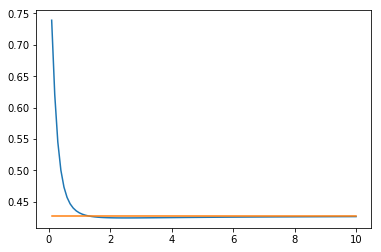

In [6]:
plt.plot(zeta_seq_2, theo_gaus)
plt.plot(zeta_seq_2, np.ones(100) * MSE_original(lbd, gamma, alpha, sigma))